In [ ]:
## Train the model using PyTorch

In [1]:
import os
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import numpy as np 
import pandas as pd
import shutil
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline

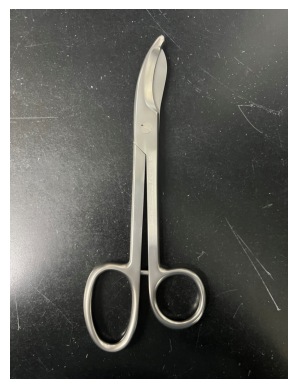

image shape: (4032, 3024, 3)


In [3]:
# Load a image
img_path = "dataset\\data-splited 3\\train\\Ciseaux à plâtre\\Ciseaux à plâtre.jpg"

with Image.open(img_path) as img:
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
    print("image shape:", np.array(img).shape)

> Using __torchvision.transforms V2__ it's faster and they can do more things. [docs link](https://pytorch.org/vision/stable/transforms.html)

In [3]:
# Path directory
dir_path = "dataset/data-splited 3"

# Data augmentation transformations (only train set)
train_transform = v2.Compose([
    v2.ToImage(),  # Convert to tensor
    v2.Resize((224, 224)),  # Resize image
    v2.RandomRotation(20),   # Random rotation
    v2.RandomAffine(degrees=0, translate=(0.2, 0.1), shear=20),
    #v2.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    # Add more transformations if needed
    v2.ToDtype(torch.float32, scale=True),
    # Normalize using Imagenet pretrianed model with its own mean and std is recommended.
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

# Data augmentation transformations for val and test sets
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((224, 224)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

# Load dataset
train_set = ImageFolder(os.path.join(dir_path, "train"), transform=train_transform)
val_set = ImageFolder(os.path.join(dir_path, "val"), transform=transform)
test_set = ImageFolder(os.path.join(dir_path, "test"), transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

In [35]:
train_set.class_to_idx

{'Ciseaux Mayo': 0,
 'Ciseaux Stevens': 1,
 'Ciseaux Stille': 2,
 'Ciseaux micro': 3,
 'Ciseaux à plâtre': 4}

In [11]:
num_classes = len(train_set.classes) 
print("Number of classes:", num_classes)

5


In [12]:
num_images = len(train_set.imgs)
print("Number of images for train set: ", num_images)

Number of images for train set:  186


1. Batching

- Efficient Training: DataLoaders group your data into mini-batches. This is essential for training deep learning models because, instead of processing one massive dataset at once, models update their weights from smaller batches, speeding up training and improving memory efficiency.
- Batch Size as a Hyperparameter: You control the batch size, which becomes a tunable aspect of your model's training process.

2. Shuffling

- Preventing Overfitting: DataLoaders can shuffle your data between epochs (complete passes through your training data). This helps prevent the model from overfitting by ensuring it sees the data in different orders during each training cycle.

3. Data Transformation 
- (On-the-fly) Data Augmentation: While you often define most of your transformations beforehand (transforms.Compose), DataLoaders can apply simple transformations as the data is being loaded into batches. This allows for on-the-fly data augmentation to further improve generalization.

4. Parallel Loading

- Speeding Things Up: DataLoaders can utilize multiple CPU cores through the num_workers argument. This means pre-processing and loading batches of data happens in parallel with model training on the GPU, reducing idle time and improving overall training speed.

In [37]:
# Extract one images and labels from train_set
for image, label in train_set:
    break

In [38]:
image.shape

torch.Size([3, 224, 224])

In [6]:
train_set.classes

['Ciseaux Mayo',
 'Ciseaux Stevens',
 'Ciseaux Stille',
 'Ciseaux micro',
 'Ciseaux à plâtre']

In [24]:
def rescale_image(image):
    min_val = image.min()
    max_val = image.max()
    return (image - min_val) / (max_val - min_val)


img_rescaled = rescale_image(image)
print(img_rescaled.min(), img_rescaled.max()) 

tensor(0.) tensor(1.)


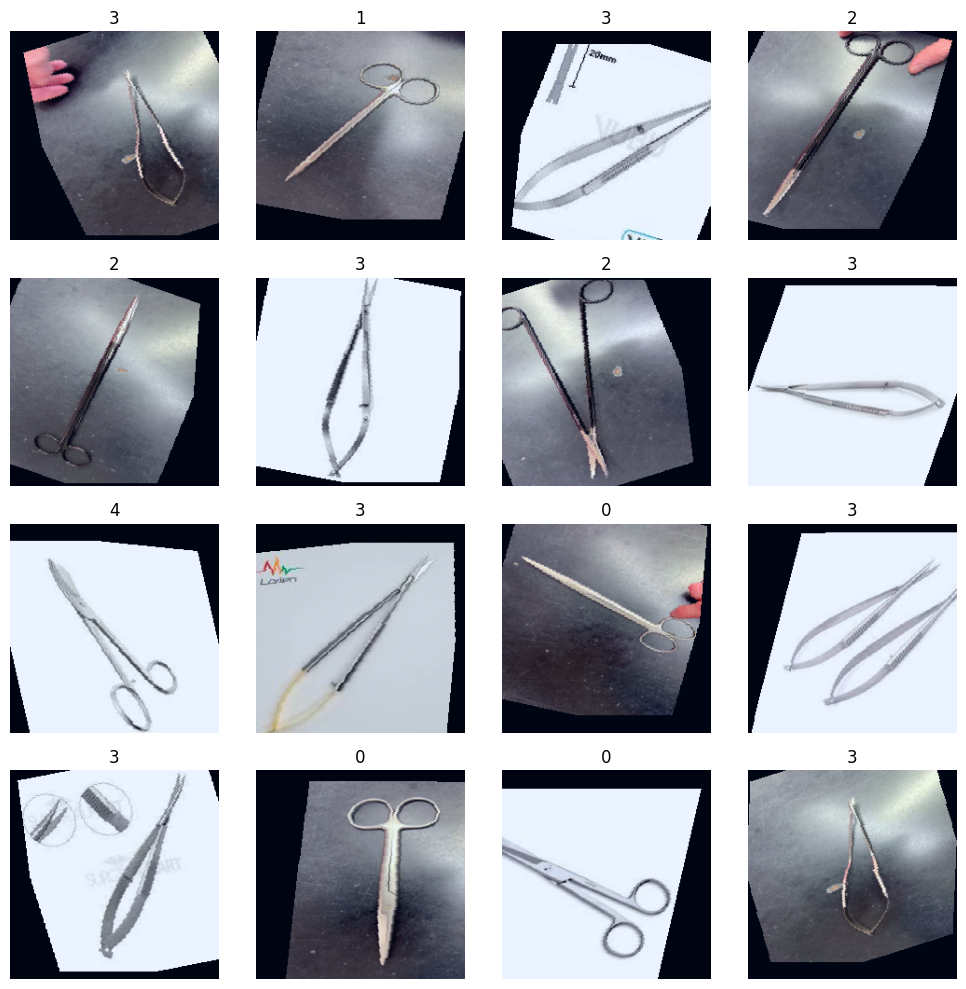

In [4]:
def rescale_image(image):
    min_val = image.min()
    max_val = image.max()
    return (image - min_val) / (max_val - min_val)


# Extract a batch of images and labels from train_set
for images, labels in train_loader:
    break


fig, axs =  plt.subplots(4,4, figsize=(10,10))

for i, ax in zip(range(16), axs.ravel()):
    img = rescale_image(images[i]) # Shift to 0-1 range
    ax.imshow(img.permute(1, 2, 0)) #  Reorders the image tensor dimensions
    ax.axis('off')
    ax.set_title(labels[i].item())
plt.tight_layout()
plt.show()

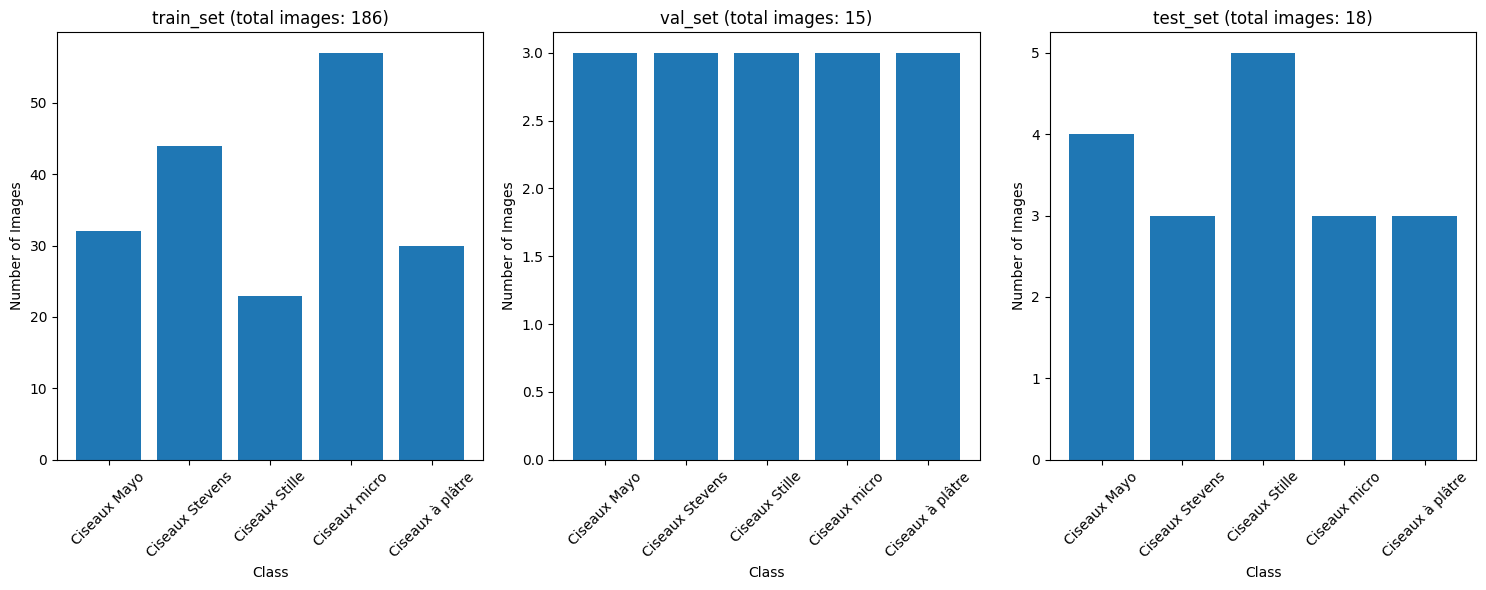

In [14]:
import collections
import matplotlib.pyplot as plt

def get_class_counts(dataset):
    class_counts = collections.defaultdict(int)  
    for _, label in dataset:
        class_counts[dataset.classes[label]] += 1
    return class_counts 


# Apply to each dataset
train_counts = get_class_counts(train_set)
val_counts = get_class_counts(val_set)
test_counts = get_class_counts(test_set)

# Plotting
set_names = ["train_set", "val_set", "test_set"]
counts_list = [train_counts, val_counts, test_counts] 

fig, axes = plt.subplots(1, 3, figsize=(15, 6))  # Adjusted figsize

for set_name, counts, ax in zip(set_names, counts_list, axes.ravel()):
    ax.bar(counts.keys(), counts.values())  # Plot directly from the dictionary
    ax.set_title(f"{set_name} (total images: {sum(counts.values())})")
    ax.set_xlabel("Class")  # More descriptive label
    ax.set_ylabel("Number of Images")
    ax.tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()


3. Custom Classification Layers

- ``x.size(0)`` : Returns the size of the 0th dimension, which is the __batch size__ (i.e., how many samples are in that batch).
- ``x.size(1)`` : Returns the __size of the 1st dimension__. The meaning of this dimension depends on the context of the tensor x. After applying ``x.view...``, this represents the __total number of features__ resulting from the flattening operation.  

1. Loading the Pre-trained Model

In [10]:
for images, labels in train_loader:
    break 

print("tensor shape:", images.shape) 

tensor shape: torch.Size([16, 3, 224, 224])


### Example of loading and summarising a pre-train mode

In [98]:
from torchsummary import summary
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

mod = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)
summary(mod.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

## Define a simple model (not use as train model)
__``super()`` gives you a way to access methods and properties from a class's parent (or superclass).__

``super(NeuralNetwork).__init__()`` specifically does the following:

Finds the parent class of NeuralNetwork (which is nn.Module)
Calls the __init__() method (constructor) of the parent class to make sure the necessary initialization steps of the nn.Module are performed within the NeuralNetwork object.

In [104]:
from torchsummary import summary
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import torch.nn as nn 

class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=len(train_set.classes)):
        super(SimpleCardClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        for param in self.base_model.parameters():
            param.requires_grad = False  # Freeze all layers initially

        mob_out_size = 62720
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(mob_out_size, num_classes),
            nn.Softmax(dim=1) 
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output
    
    
model = SimpleCardClassifer(len(train_set.classes))
print(str(model)[-500:])



ps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (18): Conv2dNormActivation(
        (0): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
    )
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=62720, out_features=5, bias=True)
    (2): Softmax(dim=1)
  )
)


In [105]:
summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
            Conv2d-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
       BatchNorm2d-4         [-1, 32, 112, 112]              64
             ReLU6-5         [-1, 32, 112, 112]               0
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]             288
            Conv2d-8         [-1, 32, 112, 112]             288
       BatchNorm2d-9         [-1, 32, 112, 112]              64
      BatchNorm2d-10         [-1, 32, 112, 112]              64
            ReLU6-11         [-1, 32, 112, 112]               0
            ReLU6-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
           Conv2d-14         [-1, 16, 1

## Check is model works

In [15]:
# Extract one images and labels from train_set
for image, label in train_set:
    break

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model(image.unsqueeze(0).to(device))

tensor([[0.1925, 0.0931, 0.1386, 0.2409, 0.3349]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

this model works!!

## Remove model , device and clean cuda 

In [39]:

import gc

del model
del device
""" gc.collect()  """

' gc.collect()  '

In [40]:
## Empty cuda cache (GPU)
torch.cuda.empty_cache()

## Define the training model

### Model 1 using ``mobilenet_v2`` (accuracy: 94%)

In [23]:
from torchsummary import summary
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import torch.nn as nn 

class NeuralNetwork(nn.Module):
    def __init__(self, num_classes=len(train_set.classes)):
        super(NeuralNetwork, self).__init__()
        # Where we define all the parts of the model
        self.base_model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        # Code the of the base model
        #for param in self.base_model.parameters():
        #    param.requires_grad = False  # Freeze all layers initially
        self.fine_tune_at = 152

        # Iterate through parameters, not layers directly
        for i, param in enumerate(self.base_model.parameters()):
            if i >= self.fine_tune_at: 
                param.requires_grad = True  # Unfreeze parameters
            else:
                param.requires_grad = False

      
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # More flexible than GlobalAveragePooling
            nn.Flatten(),
            nn.Linear(1280, 1024),  # Adjust input features
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 200),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(200, num_classes),
            nn.Softmax(dim=1) 
        )
        
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output
    
    
model = NeuralNetwork(len(train_set.classes))

summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
            Conv2d-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
       BatchNorm2d-4         [-1, 32, 112, 112]              64
             ReLU6-5         [-1, 32, 112, 112]               0
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]             288
            Conv2d-8         [-1, 32, 112, 112]             288
       BatchNorm2d-9         [-1, 32, 112, 112]              64
      BatchNorm2d-10         [-1, 32, 112, 112]              64
            ReLU6-11         [-1, 32, 112, 112]               0
            ReLU6-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
           Conv2d-14         [-1, 16, 1

### Model 2 using ``mobilenet_v3_large`` (accuracy: ... )

In [41]:
from torchsummary import summary
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
import torch.nn as nn 

class NeuralNetwork(nn.Module):
    def __init__(self, num_classes=len(train_set.classes)):
        super(NeuralNetwork, self).__init__()
        # Where we define all the parts of the model
        self.base_model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        # Code the of the base model
        #for param in self.base_model.parameters():
        #    param.requires_grad = False  # Freeze all layers initially
        self.fine_tune_at = 165

        # Iterate through parameters, not layers directly
        for i, param in enumerate(self.base_model.parameters()):
            if i >= self.fine_tune_at: 
                param.requires_grad = True  # Unfreeze parameters
            else:
                param.requires_grad = False

      
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # More flexible than GlobalAveragePooling
            nn.Flatten(),
            nn.Linear(960, 1024),  # Adjust input features
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1) 
        )
        
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        
        return output
    
    
model = NeuralNetwork(len(train_set.classes))

summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
            Conv2d-2         [-1, 16, 112, 112]             432
       BatchNorm2d-3         [-1, 16, 112, 112]              32
       BatchNorm2d-4         [-1, 16, 112, 112]              32
         Hardswish-5         [-1, 16, 112, 112]               0
         Hardswish-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             144
            Conv2d-8         [-1, 16, 112, 112]             144
       BatchNorm2d-9         [-1, 16, 112, 112]              32
      BatchNorm2d-10         [-1, 16, 112, 112]              32
             ReLU-11         [-1, 16, 112, 112]               0
             ReLU-12         [-1, 16, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             256
           Conv2d-14         [-1, 16, 1

### Check model

In [68]:
# Extract one images and labels from train_set
for image, label in train_set:
    break

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
test_output = model(image.unsqueeze(0).to(device))
test_output 

tensor([[0.1960, 0.2070, 0.2427, 0.2122, 0.1421]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

Yes it works.
Next, setup the loss and theoptimizer.

In [43]:
# Loss function
loss = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 


In [60]:
# Python library designed to display visually appealing progress bars. """ I'm not using it """
from tqdm.notebook import tqdm

## Training loop

**Note for me**
- __Weights:__ These are the learnable parameters of your neural network. Think of them as the "knobs" that the model can adjust to fit the data and make accurate predictions. During training, it's the weights that we update.

- __Gradients:__  These are vectors that provide the direction and magnitude of change needed to update the weights to minimize the loss function (error) of the model. Gradients are calculated with respect to the weights. They tell us how much and in which direction to change each weight to potentially improve the model's performance.

In [42]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# -------- Setup and Initialization the Model for Training --------

num_epochs = 40  # Number of training epochs
train_losses, val_losses = [], []  # Lists to store losses over training
train_accuracys, val_accuracys = [], []  # Lists to store accuracies

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Determine device (GPU or CPU)

# Assuming you have your NeuralNetwork class defined
model = NeuralNetwork(len(train_set.classes)) 
model.to(device)  # Send model to the selected device 

criterion = nn.CrossEntropyLoss()  # Define the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Create the optimizer 

reduce_lr_callback = ReduceLROnPlateau(optimizer, factor=0.5, patience=3, mode='min')  # Learning rate adjustment

# -------- Main Training Loop --------

for epoch in range(num_epochs):

    # -------- Training Phase --------
    model.train()  # Set the model to training mode
    running_loss = 0.0 
    total_correct = 0
    total_samples = 0

    for images, labels in train_loader:  # Iterate over batches of training data
        images, labels = images.to(device), labels.to(device)  # Move data to the device

        optimizer.zero_grad()  # Clear previous gradients 

        outputs = model(images)  # Forward pass through the model
        _, predicted = torch.max(outputs, 1)  # Get predicted class labels

        total_correct += (predicted == labels).sum().item()  # Update correct predictions
        total_samples += labels.size(0)  # Update total samples seen

        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backpropagate to compute gradients
        optimizer.step()  # Update the model's weights 

        running_loss += loss.item() * labels.size(0)  # Update running loss

    # Calculate epoch-level statistics
    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * total_correct / total_samples
    train_losses.append(train_loss)
    train_accuracys.append(train_accuracy)

    # -------- Validation Phase --------
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Temporarily disable gradient calculations
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

    # Calculate epoch-level statistics
    val_loss = running_loss / len(val_loader.dataset)
    val_accuracy = 100 * total_correct / total_samples
    val_losses.append(val_loss)
    val_accuracys.append(val_accuracy)

    # Print results
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.2f}%, Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.2f}%")

    # -------- Learning Rate Adjustment --------
    reduce_lr_callback.step(val_loss)  # Update the learning rate scheduler based on validation loss


Epoch 1/40 - Train loss: 1.5450, Train accuracy: 35.48%, Validation loss: 1.6368, Validation accuracy: 26.67%
Epoch 2/40 - Train loss: 1.4709, Train accuracy: 41.94%, Validation loss: 1.6872, Validation accuracy: 20.00%
Epoch 3/40 - Train loss: 1.3950, Train accuracy: 50.00%, Validation loss: 1.7007, Validation accuracy: 20.00%
Epoch 4/40 - Train loss: 1.3721, Train accuracy: 51.08%, Validation loss: 1.6730, Validation accuracy: 20.00%
Epoch 5/40 - Train loss: 1.3145, Train accuracy: 59.14%, Validation loss: 1.7024, Validation accuracy: 20.00%
Epoch 6/40 - Train loss: 1.2723, Train accuracy: 62.37%, Validation loss: 1.5058, Validation accuracy: 40.00%
Epoch 7/40 - Train loss: 1.2120, Train accuracy: 69.89%, Validation loss: 1.5758, Validation accuracy: 26.67%
Epoch 8/40 - Train loss: 1.2217, Train accuracy: 65.59%, Validation loss: 1.3761, Validation accuracy: 53.33%
Epoch 9/40 - Train loss: 1.1803, Train accuracy: 75.27%, Validation loss: 1.3431, Validation accuracy: 53.33%
Epoch 10/4

>**Note**<br><br>
The loss is height 1.00~ I need to check that still.

In [ ]:
# Plot the loss curve
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [ ]:
# Plot the accuracy curve
plt.plot(train_accuracys, label='Training accuracy')
plt.plot(val_accuracys, label='Validation accuracy')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

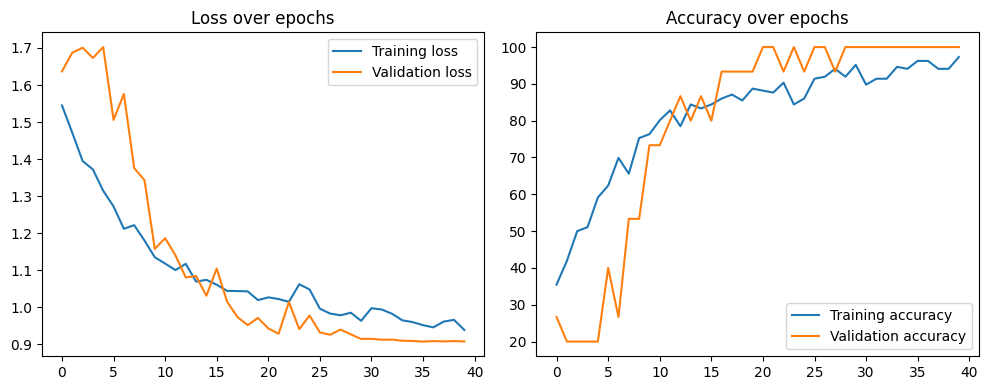

In [43]:
# Plot the loss and accuracy curve 

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

# Plot the loss curve
ax0.plot(train_losses, label='Training loss')
ax0.plot(val_losses, label='Validation loss')
ax0.legend()
ax0.set_title("Loss over epochs")

# Plot the accuracy curve
ax1.plot(train_accuracys, label='Training accuracy')
ax1.plot(val_accuracys, label='Validation accuracy')
ax1.legend()
ax1.set_title("Accuracy over epochs")

plt.tight_layout()
plt.show()


## Test the model on the test-set

In [44]:
def evaluate(model, test_loader):
  # Set model to evaluation mode
  model.eval()

  # Track total loss and number of correct predictions
  total_loss = 0
  correct_predictions = 0
  pred_class = []

  # No gradient calculation needed during evaluation
  with torch.no_grad():
    for data, target in test_loader:
    
      data, target = data.to(device), target.to(device)  # Move to device (CPU/GPU)
      output = model(data)  # Get model predictions
      # Calculate loss (e.g., cross-entropy loss for classification)
      loss = criterion(output, target)
      total_loss += loss.item()  # Accumulate loss

      # Calculate accuracy (specific metric depends on task)
      # For classification:
      _, predicted = torch.max(output.data, 1)  # Get predicted class labels
      correct_predictions += (predicted == target).sum().item()
  
      # Save the prediction classes index
      pred_class.append(predicted.cpu().data.numpy())

  # Calculate average loss and accuracy
  average_loss = total_loss / len(test_loader.dataset)
  accuracy = correct_predictions / len(test_loader.dataset)
  
  pred_class_array = np.concatenate(pred_class)
  

  # Print or return evaluation metrics (loss, accuracy)
  print(f"Test Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")
  return average_loss, accuracy, pred_class_array

average_loss, accuracy, test_pred = evaluate(model, test_loader)

Test Loss: 0.1008, Accuracy: 1.0000


In [12]:
test_set.targets

[0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4]

In [14]:
test_pred

array([0, 0, 0, 0, 1, 3, 1, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4], dtype=int64)

In [79]:
test_pred[1]

array([4, 4], dtype=int64)

In [70]:
len(test_set.targets)

18

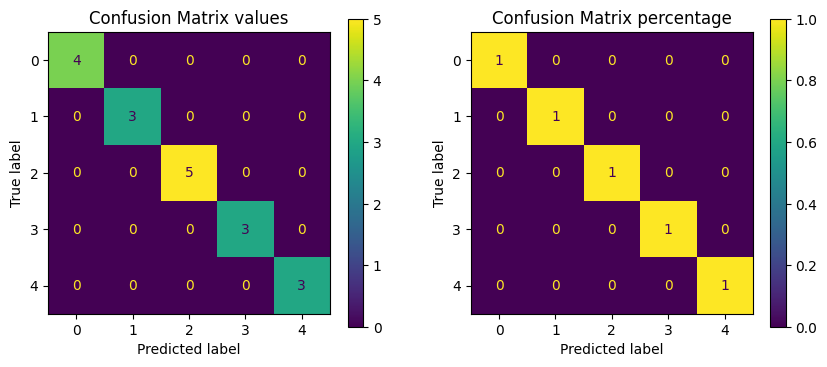

In [45]:

from sklearn.metrics import ConfusionMatrixDisplay

test_pred_labels = test_pred

true_test_pred_labels = test_set.targets

# Plot Confusion Matrix
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay.from_predictions(true_test_pred_labels, test_pred_labels, ax=ax0)
ax0.set_title("Confusion Matrix values")

ConfusionMatrixDisplay.from_predictions(true_test_pred_labels, test_pred_labels, normalize="true", ax=ax1)
ax1.set_title("Confusion Matrix percentage")
 
plt.show()

In [1]:
# Print model's state_dict
""" print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size()) """

# Print optimizer's state_dict
""" print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name]) """

' print("Optimizer\'s state_dict:")\nfor var_name in optimizer.state_dict():\n    print(var_name, "\t", optimizer.state_dict()[var_name]) '

In [51]:
# Assuming your model is on GPU
CPU_model = model.to('cpu') 

# Save all the model
torch.save(CPU_model, 'pytorch-model.pt')  

## Using the model for inference

### 1. load the model

In [53]:

# Load model
saved_model = torch.load('pytorch-model.pt')

summary(saved_model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
            Conv2d-2         [-1, 16, 112, 112]             432
       BatchNorm2d-3         [-1, 16, 112, 112]              32
       BatchNorm2d-4         [-1, 16, 112, 112]              32
         Hardswish-5         [-1, 16, 112, 112]               0
         Hardswish-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             144
            Conv2d-8         [-1, 16, 112, 112]             144
       BatchNorm2d-9         [-1, 16, 112, 112]              32
      BatchNorm2d-10         [-1, 16, 112, 112]              32
             ReLU-11         [-1, 16, 112, 112]               0
             ReLU-12         [-1, 16, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             256
           Conv2d-14         [-1, 16, 1

### 2. Loading an Image

In [49]:
def load_image(image_path):
    """Loads an image, converts to RGB format """

    with Image.open(image_path) as image:
        # Ensure RGB format (some images could be grayscale)
        image = image.convert('RGB')

    return image

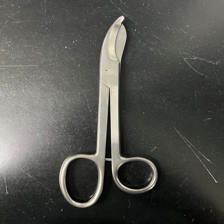

In [52]:
img = load_image(img_path)
display(img.resize((224, 224)))

### Normalization (using mean and std of model pretrianed on Imagenet)



In [56]:
def normalize_image(image):
    """Converts the image to a tensor, resize  and normalizes it."""

    transform = v2.Compose([
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224)),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image)

img_tensor = normalize_image(img)
print("tensor shape:", img_tensor.shape)

tensor shape: torch.Size([3, 224, 224])


### 4. Using the Image with a PyTorch Model

In [63]:
def predict(model, image_path):
    """Processes the image and gets prediction from the model."""

    # Load and prepare the image
    image = load_image(image_path)  
    image_tensor = normalize_image(image)

    # Add an extra batch dimension (PyTorch models expect a batch)
    image_tensor = image_tensor.unsqueeze(0)
     
    # Set the CUDA-compatible GPU if available 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    
    # Move the model to the selected device
    model.to(device) 

    # Move a tensor to the selected device
    image_tensor = image_tensor.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Get the prediction (output will be raw model output)
    output = model(image_tensor)
    
    ### Note the prediction ouput is softmax
    
    # This means data is first moved to cpu and then converted to numpy array.
    index = output.cpu().data.numpy().argmax()

    # Process the output according to your model's task 
    #  (e.g., apply softmax if doing classification)
    return index


## Run the model

In [68]:
index = predict(model, img_path)
index

4

In [73]:
train_set.class_to_idx

{'Ciseaux Mayo': 0,
 'Ciseaux Stevens': 1,
 'Ciseaux Stille': 2,
 'Ciseaux micro': 3,
 'Ciseaux à plâtre': 4}

In [76]:
class_dict = {index: name for name, index in train_set.class_to_idx.items()}
class_dict

{0: 'Ciseaux Mayo',
 1: 'Ciseaux Stevens',
 2: 'Ciseaux Stille',
 3: 'Ciseaux micro',
 4: 'Ciseaux à plâtre'}

In [77]:
class_dict[index]

'Ciseaux à plâtre'

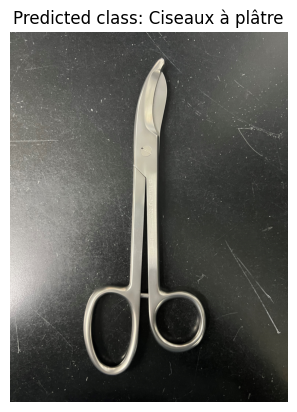

In [83]:
def get_name(model, image_path):
    index = predict(model, image_path)
    class_name = class_dict[index]
    
    # show image
    img = load_image(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted class: {class_name}")
    plt.show()
   
   
# Here I'm using the save_model  
get_name(saved_model, img_path)

In [ ]:
## Export model so I can load it in JavaScript

In [57]:
import torch.onnx

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

# 1. Load your trained PyTorch model
""" saved_model = torch.load('pytorch-model.pt')  """ # Replace with how you load your model

# 2. Set the model to evaluation mode 
saved_model.eval()

# 3. Create an example input (matching your model's input expectations)
dummy_input = torch.randn(1, 3, 224, 224).to(device) # Example for image model

# 4. Export to ONNX
torch.onnx.export(saved_model, 
                  dummy_input, 
                  "model.onnx", 
                  verbose=True, 
                  input_names=['input'],  
                  output_names=['output'])